In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline

from keras.applications.vgg16 import preprocess_input 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16prenormalized import VGG16prenormalized
from keras.preprocessing import image

Using TensorFlow backend.


In [19]:
from keras import applications

input_img = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
print(input_img)

# model = VGG16(weights='imagenet', input_tensor=input_img)
modell = VGG16prenormalized(weights='imagenet')

Tensor("Placeholder_66:0", shape=(?, 224, 224, 3), dtype=float32)


(1, 224, 224, 3)
float32


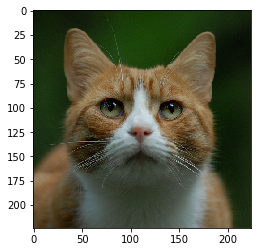

In [20]:
img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(x.shape)
print(x.dtype)
plt.imshow(img)

In [22]:
pred = modell.predict(x)

In [23]:
print(pred.shape)
print(np.argmax(pred))
print(pred)

(1, 1000)
281
[[ -1.76802921e+00   2.71066856e+00  -1.75893998e+00  -1.34884071e+00
   -9.62931633e-01   1.75447404e+00  -2.08211637e+00   3.71992514e-02
    8.87502253e-01  -8.79616916e-01  -1.49379408e+00  -7.64638305e-01
   -1.46391883e-01  -3.62586468e-01  -2.49322081e+00  -3.43829989e-01
   -1.49568975e-01   6.36347055e-01  -1.33391225e+00  -1.97687471e+00
    8.85272622e-02   1.32721996e+00  -5.33546507e-01  -5.14047444e-01
   -1.94284785e+00  -2.68083215e+00  -1.66354167e+00  -3.23240638e-01
   -3.12985396e+00  -1.96121860e+00  -2.78413391e+00  -1.37763178e+00
   -3.62550688e+00  -2.92072988e+00  -2.51171660e+00  -2.05763459e+00
   -1.12130308e+00  -2.50155926e+00   6.39042139e-01  -2.04224372e+00
    2.08090448e+00  -2.44079518e+00   4.83438075e-01  -8.77551854e-01
    1.14972842e+00  -4.45604420e+00   2.31158233e+00  -5.17310500e-01
   -4.84245825e+00  -5.32343435e+00  -3.32615876e+00  -9.02485728e-01
   -1.10410638e-01   2.84671813e-01   7.06906855e-01   1.06543958e+00
   -2.

# keras model + tensorflow execution 

In [26]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(InputLayer(input_tensor=input_img,
                     input_shape=(None, 224, 224, 3)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))


model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dense(1000, activation='linear', name='predictions'))
          
output_tensor = model.output

In [16]:
import tensorflow as tf 
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

In [32]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [33]:
from keras.utils.data_utils import get_file
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'


weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
model.load_weights(weights_path)


In [36]:
index = np.argmax(output_tensor[0])
loss = output_tensor[0][index]

In [37]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

print(grads)

Tensor("truediv:0", shape=(?, 224, 224, 3), dtype=float32)


In [38]:
with sess.as_default():
    res, saliency_map = sess.run([output_tensor, grads], feed_dict={input_img: x})

print(np.argmax(res[0]))
print(res[0].shape)

281
(1000,)


(1, 224, 224, 3)
[[[[ 0.04407986  0.11042021  0.10699306]
   [ 0.07347474  0.20523693  0.16553839]
   [ 0.03856516  0.25935268  0.12265503]
   ..., 
   [-0.42464983 -0.09744837 -0.33377233]
   [-0.30331707 -0.17262177 -0.24088652]
   [-0.20101875 -0.16037141 -0.17775902]]

  [[ 0.25200254  0.38909024  0.35696003]
   [ 0.32197455  0.55267078  0.45215926]
   [ 0.15835911  0.49333221  0.23785558]
   ..., 
   [-0.22255644  0.58103156  0.06739294]
   [ 0.18534508  0.69061917  0.44979471]
   [ 0.01457284  0.2448085   0.14022832]]

  [[ 0.21048856  0.35737795  0.2813707 ]
   [ 0.17488384  0.37756699  0.21213123]
   [-0.22652109 -0.02158456 -0.34251267]
   ..., 
   [-0.05601767  0.92498833  0.27258936]
   [ 0.65239418  1.3283416   1.01506507]
   [ 0.32992876  0.67447352  0.52788407]]

  ..., 
  [[ 0.45631009 -0.12196986 -0.15108481]
   [-0.88005674 -2.36568284 -2.30539918]
   [-1.38135183 -2.98242855 -2.97864366]
   ..., 
   [-0.03713091  0.46280113  0.9614926 ]
   [ 0.01338165  0.21538065  0.

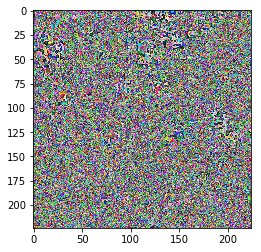

In [39]:
print(saliency_map.shape)
print(saliency_map)
plt.imshow(saliency_map[0])

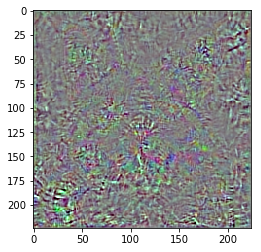

In [40]:
from scipy.misc import imsave
from matplotlib import pyplot as plt
%matplotlib inline 

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5    # center to 0.5 for the [0, 1] interval
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = saliency_map[0]
img = deprocess_image(img)
plt.imshow(img)